<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Other-functions" data-toc-modified-id="Other-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other functions</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Options" data-toc-modified-id="Options-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Options</a></span></li><li><span><a href="#Spectral" data-toc-modified-id="Spectral-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Spectral</a></span></li><li><span><a href="#K-means" data-toc-modified-id="K-means-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>K-means</a></span></li><li><span><a href="#Graphs" data-toc-modified-id="Graphs-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Graphs</a></span></li></ul></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualize</a></span></li><li><span><a href="#Chart-the-returns-of-the-formed-clustes" data-toc-modified-id="Chart-the-returns-of-the-formed-clustes-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Chart the returns of the formed clustes</a></span></li><li><span><a href="#Analysing-clusters" data-toc-modified-id="Analysing-clusters-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Analysing clusters</a></span></li></ul></div>

# Clustering

## Description

- Cluster funds using Spektral Clustering

## Setup

In [1]:
import feather
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

In [2]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)
le = LabelEncoder()
row_info['lipper_class_num'] = le.fit_transform(row_info['lipper_class'])

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

## Other functions

In [3]:
def filter_data(year, verbose = False):
    
    verbose = param['verbose']
    year = param['year']
        
    row_info_f = row_info.copy()
    if (year != 'full'):    # If year = full take whole sample
        row_info_f = row_info_f.query('year == @year')

    begin_date = row_info_f.iloc[0,:]['report_dt']
    end_date = begin_date + pd.DateOffset(years=1, months=1, days = 5) # 1 year offset
    row_info_f.reset_index(drop = True, inplace=True)

    # Filter returns
    crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
    returns_f = returns.copy()
    query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
    returns_f = returns_f.query(query)

    # Change return of month for which holdings apply to 0
    returns_f = returns_f.copy()
    mask = returns_f['report_dt'] == begin_date
    returns_f.loc[mask,'mret'] = 0

    # Filter holdings accordingly and delet all securities with less than two observations
    holdings_f = holdings.copy()
    holdings_f = holdings[row_info_f['row']]
    
    holdings_b = sparse.csr_matrix(holdings_f, copy=True)
    holdings_b.data = np.ones(len(holdings_f.data))

    sum_sec_boolean = holdings_b.toarray().sum(0)
    col_mask = (sum_sec_boolean >= 2).flatten()

    holdings_f = holdings_f.tocsc()
    holdings_f = holdings_f[:,col_mask]
    holdings_f = holdings_f.tocsr()
    
    ## Preprocessing
    holdings_ft = normalize(holdings_f)
    
    if (verbose):
        print('Numer of unique funds:           {:10,d}'.format(row_info_f.shape[0]))

        print('Numer of unique securities:      {:10,d}'.format(holdings_ft.shape[1]))

        print('Begin date:                      {}'.format(begin_date.date()))
        print('End date:                        {}'.format(end_date.date()))
    
    return(row_info_f, returns_f, holdings_ft, begin_date, end_date)

In [4]:
def spectral_clustering(holdings_ft, param):
    verbose = param['verbose']

    if(verbose): print('Start clustering...')
    clustering = SpectralClustering(n_clusters = param['n_clusters'],
                                    assign_labels = param['assign_labels'], # kmeans or discretize
                                    eigen_solver = 'arpack',
                                    affinity = param['affinity'],
                                    gamma = param['gamma'],
                                    n_init = param['n_init'],
                                    n_jobs = -1,
                                    random_state = 0).fit(holdings_ft)
    if(verbose): print('Clustering finished')
    
    return(clustering)

In [5]:
def kmeans_clustering(holdings_ft, param):
    verbose = param['verbose']

    if(verbose): print('Start clustering...')
    clustering = KMeans(n_clusters = param['n_clusters'],
                        verbose = verbose,
                        n_init = param['n_init'], # Number of runs
                        n_jobs= -1,
                        random_state = 1
                       ).fit(holdings_ft)
    
    if(verbose): print('Clustering finished')
    
    return(clustering)

## Test

In [6]:
def calc_styleadj_returns(row_info_f,returns_f,style_cols):

    row_info_m = row_info_f.copy()
    returns_m = returns_f.copy()
    cols = style_cols
    
    returns_m = returns_m.sort_values(['crsp_fundno','report_dt'])

    col = 'cluster'

    # merge predicted styles onto returns
    returns_m = returns_m.merge(row_info_m[['crsp_fundno', 'report_dt', col]],
                            how='left',
                            on=['crsp_fundno', 'report_dt'])

    # Drop all funds with first return observation after starting date
    drop_fundnos = returns_m.drop_duplicates('crsp_fundno').query('mret != 0')['crsp_fundno']
    temp = returns_m.query('crsp_fundno not in @drop_fundnos')

    # Forward fill all styles and drop nas
    returns_m = (temp
                        .apply(lambda x: x.fillna(method = 'ffill'))
    )

    # Calc mean return per style
    style_returns = (returns_m
                        .groupby([col,'report_dt'])
                        .mean()
                        .reset_index()
                        .drop(columns='crsp_fundno')
    )

    # Merge style returns onto fund returns and calc tracking error
    returns_m = (returns_m
                        .rename(columns = {'mret' : 'fund_ret'}) 
                        .merge(style_returns,
                                    how = 'left',
                                    on = [col,'report_dt'])
                        .assign(error = lambda df: df['fund_ret'] - df['mret'])
                        .rename(columns = {'mret' : 'style_ret'}) 
    )

    returns_m = returns_m[['crsp_fundno', 'report_dt', col,
                       'fund_ret', 'style_ret', 'error']]

    return(returns_m, style_returns)

In [20]:
def error_vola_deciles(returns_m): 
    error_vol = (returns_m
                 .groupby(['crsp_fundno'])['error']
                 .std()
                 .reset_index())
    error_vol['error'] = error_vol['error'] * 100
    
    error_vol = (error_vol[['error']]
                .apply(lambda x : x.quantile(np.round(np.arange(0.1,1,0.1),2))))
    return(error_vol)

def error_vola_describe(returns_m): 
    error_vol = (returns_m
                 .groupby(['crsp_fundno'])['error']
                 .std()
                 .reset_index())
    error_vol['error'] = error_vol['error'] * 100
    return(error_vol[['error']].describe().T)

In [40]:
returns_s = returns_m

In [8]:
def plot_cluster(row_info_f, style, ax):
    data = round(
        pd.crosstab(
            row_info_f[style],row_info_f['cluster'], 
            margins = True, normalize = 'columns') * 100, 2).T

    data.plot(kind='bar', 
                 stacked=True, ax = ax)

    ax.legend().remove()
    label_list = data.columns.values.astype(str).repeat(data.shape[0])
    rects = ax.patches

    # For each bar: Place a label
    for i, rect in enumerate(rects):
        if rect.get_height() > 10:
            # Get X and Y placement of label from rect.
            x_value = rect.get_x() + rect.get_width() / 2
            y_value = rect.get_y() + rect.get_height() / 2

            # Use X value as label and format number with one decimal place
            label = "{}".format(label_list[i])

            # Create annotation
            ax.annotate(
                label,                        # Use `label` as label
                (x_value, y_value),           # Place label at end of the bar
                xytext = (0, 0),              # Horizontally shift label by `space`
                textcoords = 'offset points', # Interpret `xytext` as offset in points
                va='center',                  # Vertically center label
                ha='center',
                color = 'white',
                size = 12)                  # Horizontally align label 
    return(ax)
    
def plot_cluster_wrapper(row_info_f):
    
    f, axes = plt.subplots(nrows = 4, ncols=1, sharex=True, 
                           figsize = (15,6), gridspec_kw={'height_ratios':[1,2,2,2]})
    
    data = row_info_f['cluster'].value_counts(sort=False).append(to_append = pd.Series([0]))
    data.plot(kind='bar', ax = axes[0])
    axes[0].annotate('Total: {:,d}'.format(np.sum(data)),(5,100),ha ='center')

    plot_cluster(row_info_f,'cap_class', ax = axes[1])
    plot_cluster(row_info_f,'style_class', ax = axes[2])
    plot_cluster(row_info_f,'lipper_class', ax = axes[3])

In [9]:
def expand_grid(dictionary):
    temp = pd.DataFrame([row for row in product(*dictionary.values())], 
                           columns=dictionary.keys())
    return(temp)

In [10]:
def weighted_average_score(param_grid, relevant_params, measures):


    param_grid['param_id'] = (param_grid
                                  .groupby(relevant_params)
                                  .ngroup())
        
    scores = param_grid[measures]
    params_only = param_grid.drop(columns = measures)
    
    weights = (param_grid[['year','count']]
                                  .drop_duplicates()
                                  .assign(weight = lambda x: x['count'] / np.sum(x['count'])))
    weights = weights[['weight']].values

    scores = scores.groupby(params_only['param_id']).apply(lambda x: np.sum(x * weights))

    params_only = (params_only
                      .drop_duplicates(relevant_params)
                      .drop(columns = ['year','count']))

    result = params_only.merge(scores, how = 'left', on = 'param_id')
    
    return(result)

## Clustering

### Options

In [11]:
full = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
param = dict(
    year             = [2016],         # Integer or string 'full' for the whole sample
    n_clusters       = [12,14],
    assign_labels    = ['kmeans'],       # 'kmeans' or 'discretize'
    affinity         = ['rbf'],          # One of: rbf, nearest_neighbors
    gamma            = [1],              # Sigma for rbf kernal
    n_init           = [10],            # N init of kmeans
    style_class      = ['lipper_class'], # Choose lipper_class, style_class or cap_class    
    verbose          = [False]
)

param_grid = expand_grid(param)

### Spectral

In [12]:
for i, param in param_grid.iterrows():
    row_info_f, returns_f, holdings_ft, begin_date, end_date = filter_data(param)
    clustering = spectral_clustering(holdings_ft, param)
    row_info_f = row_info_f.assign(cluster = clustering.labels_)
    
    holdings_ft_array = holdings_ft.toarray()
    db_score = davies_bouldin_score(holdings_ft_array, row_info_f['cluster'])
    s_score = silhouette_score(holdings_ft, row_info_f['cluster'])
    
    param_grid.loc[i,'count'] = row_info_f.shape[0]
    param_grid.loc[i,'DB score'] = db_score
    param_grid.loc[i,'Silhouette score'] = s_score
    
    param_grid.loc[i,'DB score lipper'] = davies_bouldin_score(holdings_ft_array, row_info_f['lipper_class_num'])
    param_grid.loc[i,'Silhouette score lipper'] = silhouette_score(holdings_ft, row_info_f['lipper_class_num'])

In [22]:
result = weighted_average_score(param_grid,
                                relevant_params = ['n_clusters','assign_labels','affinity','gamma','n_init'], 
                                measures = ['DB score','Silhouette score'])
result = result.drop(columns = ['style_class','verbose'])
result

,n_clusters,assign_labels,affinity,gamma,n_init,DB score lipper,Silhouette score lipper,param_id,DB score,Silhouette score
0,12,kmeans,rbf,1,10,7.175963,0.013095,0,4.430096,0.016716
1,14,kmeans,rbf,1,10,7.175963,0.013095,1,3.935142,0.004694


In [25]:
returns_m, style_returns = calc_styleadj_returns(row_info_f, returns_f, style_cols='cluster')
temp = error_vola_describe(returns_m)
temp

,count,mean,std,min,25%,50%,75%,max
error,1901.0,1.153068,1.239646,0.09582,0.688588,0.943072,1.307239,27.609627


### K-means

In [331]:
for i, param in param_grid.iterrows():
    row_info_f, returns_f, holdings_ft, begin_date, end_date = filter_data(param)
    clustering = kmeans_clustering(holdings_ft, param)
    row_info_f = row_info_f.assign(cluster = clustering.labels_)
    
    holdings_ft_array = holdings_ft.toarray()
    db_score = davies_bouldin_score(holdings_ft_array, row_info_f['cluster'])
    s_score = silhouette_score(holdings_ft, row_info_f['cluster'])
    
    param_grid.loc[i,'count'] = row_info_f.shape[0]
    param_grid.loc[i,'DB score'] = db_score
    param_grid.loc[i,'Silhouette score'] = s_score
    
    param_grid.loc[i,'DB score lipper'] = davies_bouldin_score(holdings_ft_array, row_info_f['lipper_class_num'])
    param_grid.loc[i,'Silhouette score lipper'] = silhouette_score(holdings_ft, row_info_f['lipper_class_num'])

In [332]:
result = weighted_average_score(param_grid)
result = result.drop(columns = ['style_class','verbose'])
result

,n_clusters,assign_labels,affinity,gamma,n_init,DB score lipper,Silhouette score lipper,param_id,DB score,Silhouette score
0,12,kmeans,rbf,1,500,7.256829,0.011036,0,4.501273,0.041916


In [333]:
returns_m, style_returns = calc_styleadj_returns(row_info_f, returns_f)
temp = error_vola_describe(returns_m)
temp.T

,count,mean,std,min,25%,50%,75%,max
error,2072.0,1.064154,0.626305,0.066777,0.659697,0.915888,1.296163,7.277913


In [325]:
result = weighted_average_score(param_grid)
result = result.drop(columns = ['style_class','verbose'])
result

,n_clusters,assign_labels,affinity,gamma,n_init,DB score lipper,Silhouette score lipper,param_id,DB score,Silhouette score
0,12,kmeans,rbf,1,100,7.256829,0.011036,0,4.412439,0.032837


In [326]:
returns_m, style_returns = calc_styleadj_returns(row_info_f, returns_f)
temp = error_vola_describe(returns_m)
temp.T

,count,mean,std,min,25%,50%,75%,max
error,2072.0,1.072968,0.628306,0.147778,0.661423,0.921477,1.304039,7.156736


### Graphs

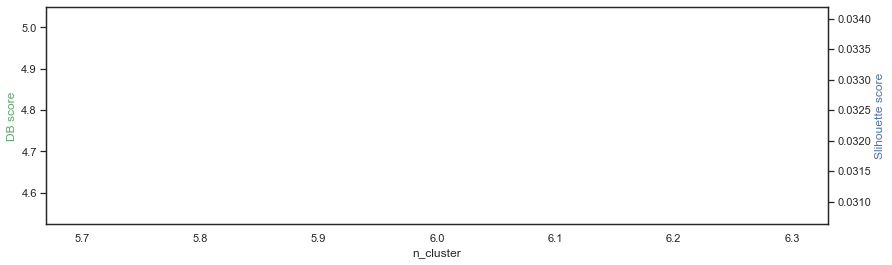

In [107]:
fig, ax1 = plt.subplots(figsize = (14,4))

ax2 = ax1.twinx()

sns.lineplot(data = result ,x = 'n_clusters', y='DB score', color='g', ax=ax1)
sns.lineplot(data = result ,x = 'n_clusters', y='Silhouette score', ax=ax2)

ax1.set_xlabel('n_cluster')
ax1.set_ylabel('DB score', color='g')
ax2.set_ylabel('Slihouette score', color='b')

plt.show()

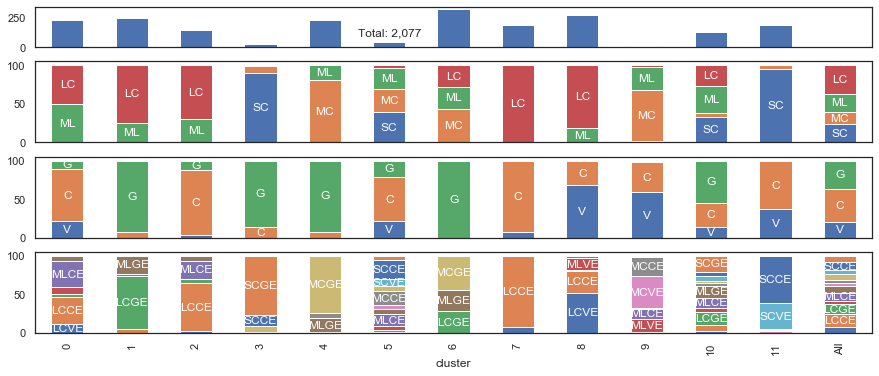

In [334]:
plot_cluster_wrapper(row_info_f)

## Visualize

In [ ]:
### Based on example code from sklearn ###

X = holdings_ft
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,18,25]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = SpectralClustering(
                    n_clusters=n_clusters,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(X)
    clusters.append(n_clusters)
    #results.append(cluster_fit.inertia_)    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          'The average silhouette_score is: {}'.format(round(silhouette_avg,4)))

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Chart the returns of the formed clustes

In [ ]:
row_info.sample()

#### Merge new clusters into returns

In [ ]:
returns_merged = returns.merge(row_info, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','crsp_portno','mret','lipper_class','cluster']]
returns_merged.sample()

#### Calc mean return per Obj_cd

In [ ]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

In [ ]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [ ]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Analysing clusters

In [ ]:
plt.plot(kmeans.cluster_centers_[0,:])

In [ ]:
plt.plot(kmeans.cluster_centers_[1,:])

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Other-functions" data-toc-modified-id="Other-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other functions</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Options" data-toc-modified-id="Options-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Options</a></span></li><li><span><a href="#Spectral" data-toc-modified-id="Spectral-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Spectral</a></span></li><li><span><a href="#K-means" data-toc-modified-id="K-means-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>K-means</a></span></li></ul></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize</a></span></li><li><span><a href="#Chart-the-returns-of-the-formed-clustes" data-toc-modified-id="Chart-the-returns-of-the-formed-clustes-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Chart the returns of the formed clustes</a></span></li><li><span><a href="#Analysing-clusters" data-toc-modified-id="Analysing-clusters-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Analysing clusters</a></span></li></ul></div>